In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets , transforms, models
from torch.utils.data import DataLoader


import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406] , std=[.229 ,.224 ,.225])
])

In [3]:
train_data = datasets.ImageFolder(('Training'),transform = transform)
test_data = datasets.ImageFolder(('Testing'),transform = transform)

In [4]:
train_loader = DataLoader(train_data , batch_size=32 , shuffle =True)
test_loader = DataLoader(test_data , batch_size=32 , shuffle =False)

In [5]:
class TumorClassifier(nn.Module):
    def __init__(self):
        super(TumorClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # Adjust the input size of the fc1 layer
        self.fc2 = nn.Linear(512, 4)  # 4 classes for classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Flatten the tensor for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = TumorClassifier()


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [7]:
epochs = 10 

for epoch in range(epochs):
    running_loss = 0.0
    for images , labels in train_loader:
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output , labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(F'Epochs {epoch+1} , Loss: {running_loss/len(train_loader):.4f}')


Epochs 1 , Loss: 1.9557
Epochs 2 , Loss: 0.2525
Epochs 3 , Loss: 0.0830
Epochs 4 , Loss: 0.0342
Epochs 5 , Loss: 0.0112
Epochs 6 , Loss: 0.0127
Epochs 7 , Loss: 0.0025
Epochs 8 , Loss: 0.0003
Epochs 9 , Loss: 0.0002
Epochs 10 , Loss: 0.0001


In [8]:
correct = 0 
total = 0

with torch.no_grad():
    for images , labels in test_loader:
        outputs = model(images)
        _ , predicted = torch.max(outputs.data , 1)
        total += labels.size(0)
        correct  += (predicted == labels).sum().item()
print(f"ACCURACY :{100 * correct/total}")

ACCURACY :73.85786802030456


In [9]:
model.eval()  # Set the model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


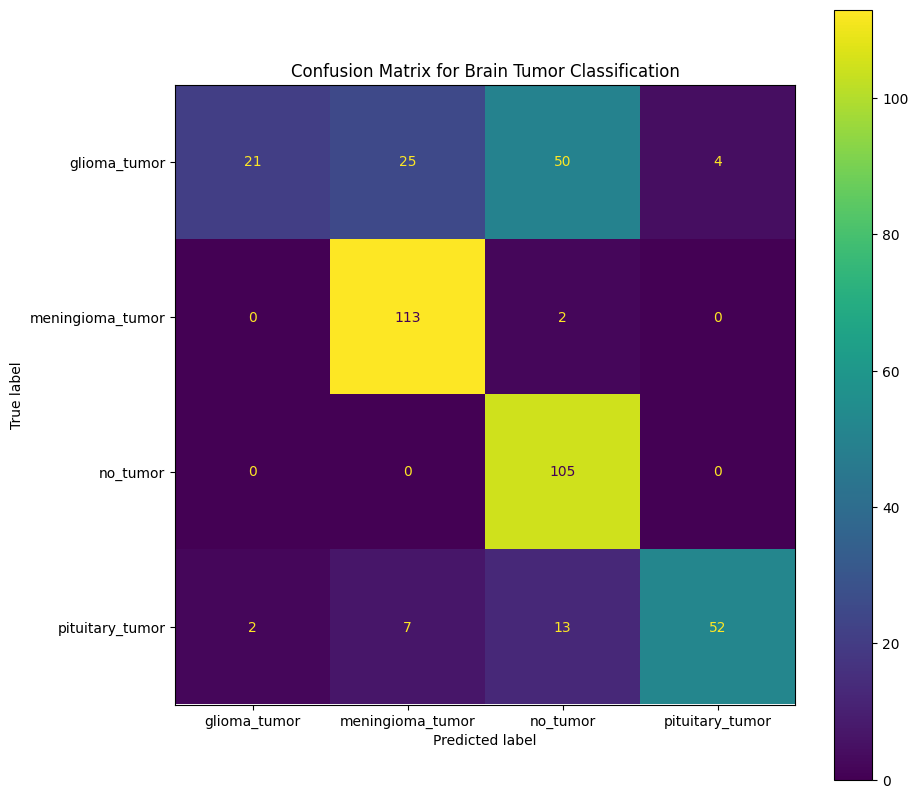

In [10]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.title('Confusion Matrix for Brain Tumor Classification')
plt.show()


In [11]:
from PIL import Image

In [12]:
image_path = 'pit.jpeg'  # Replace with the path to your image
image = Image.open(image_path)
image = transform(image)
image = image.unsqueeze(0)  # Add batch dimension


In [13]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)
    class_idx = predicted.item()

# Map the predicted index to the corresponding class label
class_labels = train_data.classes
predicted_class = class_labels[class_idx]

print(f'The model predicts: {predicted_class}')


The model predicts: meningioma_tumor


In [14]:
import torch
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


In [15]:
model.eval()  # Set the model to evaluation mode

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())


In [16]:
print(classification_report(all_labels, all_preds, target_names=train_data.classes))


                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.21      0.34       100
meningioma_tumor       0.78      0.98      0.87       115
        no_tumor       0.62      1.00      0.76       105
 pituitary_tumor       0.93      0.70      0.80        74

        accuracy                           0.74       394
       macro avg       0.81      0.72      0.69       394
    weighted avg       0.80      0.74      0.69       394



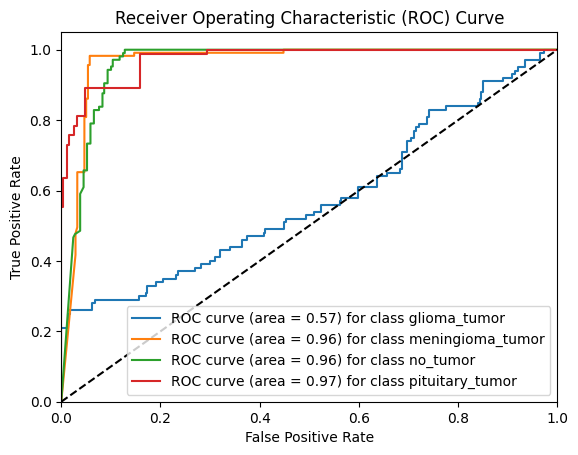

In [17]:
# Binarize the labels
from sklearn.preprocessing import label_binarize
n_classes = len(train_data.classes)
all_labels_bin = label_binarize(all_labels, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], [prob[i] for prob in all_probs])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_bin.ravel(), np.array(all_probs).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {train_data.classes[i]}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
